In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
/*================================================================
*   Copyright (C) 2018. All rights reserved.
*   Author：Leon Wang
*   Date：Thu Jul 26 21:19:35 2018
*   Email：leonwang@bu.edu
*   Description： Random Forest Algorithm to predict stock returns
================================================================*/
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
sns.set(color_codes=True)

/share/pkg/python/3.6.1/install/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/share/pkg/python/3.6.1/install/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
clean_data_mktcap=pd.read_csv("clean_data_mktcap.csv",index_col=0)

# Preparation for Calculating the VIF, Cell added by Leon

# drop irrelevant columns
clean_data_mktcap_vif=clean_data_mktcap.drop(['pricedelay','permno','DATE','datadate','IPO','age','mve'],axis=1)

# drop correlated columns from paper
clean_data_mktcap_vif=clean_data_mktcap_vif.drop(['betasq', 'dolvol', 'lgr', 'maxret', 'mom6m', 'pchquick', 'quick', 'stdacc'],axis=1)


In [48]:
"""

from statsmodels.stats.outliers_influence import variance_inflation_factor
non_float=clean_data_mktcap_vif.dtypes[clean_data_mktcap_vif.dtypes!='float64'].index
data_float=clean_data_mktcap_vif.drop(non_float,axis=1)
data_float=data_float.dropna(how='any',axis=1)



vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_float.values, i) for i in range(data_float.shape[1])]
vif["features"] = data_float.columns

# Select Variables that have high VIF value
vif[vif['VIF Factor']>7]
high_corr_variables=vif[vif['VIF Factor']>7]['features'].tolist()



# Plot the Cross Correlation, Cell added by Leon
corr_matrix=np.abs(clean_data_mktcap_vif.corr())
# Plot the original correlation matrix
corr_values=corr_matrix.values.ravel()
corr_values=corr_values[corr_values!=1]
pd.DataFrame(corr_values).plot.hist(legend=False,title='Before Killing VIF')
plt.show()


# Plot the correlation matrix after killing the high VIF Variables
killed_corr_matrix=corr_matrix.drop(high_corr_variables,axis=1)
killed_corr_matrix=np.abs(killed_corr_matrix.corr())
killed_corr_values=killed_corr_matrix.values.ravel()
killed_corr_values=killed_corr_values[killed_corr_values!=1]

pd.DataFrame(killed_corr_values).plot.hist(legend=False,title='After Killing VIF')
plt.show()

"""

KeyboardInterrupt: 

In [3]:
# Random Forest Algorithm 

class Random_Forest:
    """
        Class to train random forest to predict stock returns by using cleaned factors
    """
    def __init__(self,features,labels,test_features,test_labels,tree_num):
        """
            Method to initilize the Random Forest Alogorithm
            params: features, np.array of n_obs x n_variables features of training set
            params: labels, np.array of n_obs x 1 training labels
            params: test_features, np.array of n_obs x n_variables features of testing set
            params: test_labels, np.array of n_obs x 1 predicting labels
            params: tree_num number of trees in the forest
        """
        # The original training features
        self.origin_features=features 
        
        # The original training labels
        self.origin_labels=labels
        
        # The tree num specified
        self.tree_num=tree_num
        
        # The original testing features
        self.origin_test_features=test_features
        
        # The original testing labels
        self.origin_test_labels=test_labels
        
    def init_train(self):
        """
            Method to execute the training process
        """
        rf_exp = RandomForestRegressor(n_estimators= self.tree_num)
        self.rf=rf_exp.fit(self.origin_features, self.origin_labels)
        self.features_name=self.origin_features.columns    
    def init_pred(self):  
        """
            Method to predict the labels, need to be excuted after method init_train
            :return an np.array of prediction by using trained rf model
        """
        predictions = self.rf.predict(self.origin_test_features)
        return predictions
    
    def key_features(self):
        """
            Method to calculate the importance of each feature, return a sorted[from highest to the lowest] dataframe of features with their importantance
            :return pd.Dataframe of important feacture table
        """
        importances = list(self.rf.feature_importances_)
        key_features_table=pd.DataFrame([self.features_name,importances]).T
        key_features_table.columns=['Features','Importance']
        return key_features_table.sort_values(by='Importance',ascending=False)
    def importance_plot(self):
        """
            Method to plot the key_features' importance
        """
        # First plot the Importance Table from key_features dataframe
        key_features_table=self.key_features()        
        x_values=list(range(len(key_features_table)))
        plt.bar(x_values, key_features_table['Importance'].values, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
        plt.xticks(x_values, key_features_table['Features'].values, rotation='vertical')
        plt.title='Importance of Each Variable'
        plt.show()
        
        # Second plot the cumulative importance from key features dataframe
        cumulative_importances = np.cumsum(key_features_table['Importance'])
        plt.plot(x_values, cumulative_importances, 'g-')
        plt.hlines(y = 0.95, xmin=0, xmax=len(key_features_table['Importance']), color = 'r', linestyles = 'dashed')
        plt.xticks(x_values, key_features_table['Features'], rotation = 'vertical')
        plt.xlabel='Variable'
        plt.ylabel='Cumulative Importance'
        plt.title='Cumulative Importances'
        plt.show()
        print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)
    
    def adjusted_imp_features(self,maximum_fea_num):
        """
            Method to return the adjusted training set by using important features
            :params maximum_fea_num, int, the maximum number of features specififed to use for prediction
        """
        key_features_table=self.key_features()
        adjusted_train=self.origin_features.iloc[:,list(key_features_table.iloc[:maximum_fea_num].index)]
        adjusted_test=self.origin_test_features.iloc[:,list(key_features_table.iloc[:maximum_fea_num].index)]
        self.adjusted_train=adjusted_train
        self.adjusted_test=adjusted_test
    def imp_train(self):
        """
            Method to re-train the model by using only important features
        """
        rf_exp=RandomForestRegressor(n_estimators= self.tree_num)
        self.imp_rf=rf_exp.fit(self.adjusted_train, self.origin_labels)
        self.imp_features_name=self.adjusted_train.columns
        
    def imp_pred(self):
        """
            Method to predict using the only important features
            :return an array of prediction by using important features trained rf model
        """
        imp_predictions = self.imp_rf.predict(self.adjusted_test)
        return imp_predictions

    def return_best_stocks(self,max_fea_num,stock_num):
        """
            Method that return the predicted best performing stock tickers
            :params maximum_fea_num, int, the maximum number of features specififed to use for prediction
            :params stock_num, the top # of stocks for portfolio construction
            :reutrn an np.array of stock permenant numbers
        """
        self.init_train()
        self.adjusted_imp_features(max_fea_num)
        self.imp_train()
        final=pd.DataFrame([self.origin_test_features['permno'].values,self.imp_pred()]).T
        final.columns=['Permno','Predicted_Return']
        final=final.sort_values(by='Predicted_Return',ascending=False)

        return final['Permno'].iloc[:stock_num].values

In [4]:
def calc_mkt_ret(groupdata):
    groupdata['mkt_ret'] = np.average(groupdata['RET'],weights = groupdata['mve_m'])
    return groupdata


# From G's code to compare to the market
simple_ret = []
weighted_ret = []
mkt_ret_list = []


In [1]:
"""
Include certain describtive columns
"""

clean_data_mktcap_vif['permno']=clean_data_mktcap['permno'].values

data_all=clean_data_mktcap_vif

data_all=data_all.groupby(['year','month']).apply(calc_mkt_ret)

data_all['mve_lg'] = np.log(data_all['mve_m'].values) 


NameError: name 'clean_data_mktcap' is not defined

In [6]:
start_year = np.amin(data_all['year'])
data_all['test_period'] = ((data_all['year'].values - start_year) * 12 + data_all['month'].values)
num_period = np.amax(data_all['test_period'])


#for period_indx in range(1,int(num_period-12)):
for period_indx in range(1,3):
    print(period_indx)
    # training data
    data_year = data_all.loc[np.in1d(data_all['test_period'],list(range(period_indx,period_indx+12))),:].reset_index(drop=True)
    # test data
    data_test = data_all[(data_all['test_period']==(period_indx+12))].reset_index(drop=True)
    
    train_labels=data_year['RET']
    train_features=data_year.drop(['RET','month','year','test_period','mve_m'],axis=1)
    
    test_labels=data_test['RET']
    test_features=data_test.drop(['RET','month','year','test_period','mve_m'],axis=1)
    
    
    temp=Random_Forest(train_features,train_labels,test_features,test_labels,10)


    permno_pick=temp.return_best_stocks(max_fea_num=20,stock_num=10)
    
    # strategy realization
    # .......
    # return permno_pick: an array that contains the companies that the strategy picks
    # 


# permno_pick, array, contains the company that is being selected, 
    ret_pick = data_test.loc[np.in1d(data_test['permno'],permno_pick ),'RET']
    mve_pick = data_test.loc[np.in1d(data_test['permno'],permno_pick ),'mve_m']

    
    simple_ret.append(np.mean(ret_pick))
    weighted_ret.append(np.average(ret_pick,weights = mve_pick.values))
    mkt_ret_list.append(np.unique(data_test['mkt_ret']))

1
2
3
4


KeyboardInterrupt: 

In [7]:
#mean_squared_error(temp.imp_pred())
temp=Random_Forest(train_features,train_labels,test_features,test_labels,10)
temp.init_train()
y_hat=temp.init_pred()
y=temp.origin_test_labels
r_sqaure=sum((y-y_hat)**2)/sum(y**2)
print('r_sqaure='+str(r_sqaure))



r_sqaure=0.767615231805


In [ ]:
temp.adjusted_imp_features(20)
temp.imp_train()
y_hat=temp.imp_pred()
r_sqaure_imp=sum((y-y_hat)**2)/sum(y**2)
print('r_sqaure_imp='+str(r_sqaure_imp))

r_sqaure_imp=0.757767902232


In [ ]:
temp.rf.get_params()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 2)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
random_grid = {'n_estimators': n_estimators,}
#              'max_features': max_features}
rf_random = GridSearchCV(estimator = temp.rf, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)


rf_random.fit(train_features, train_labels)



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  45.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   45.3s remaining:    0.0s


[CV] ................................. n_estimators=100, total=  44.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  45.8s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  47.6s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  46.3s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total= 2.3min
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total= 2.2min
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total= 2.3min
[CV] n_estimators=300 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.2min finished


In [31]:
rf_random.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)

    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)

    
    plt.tight_layout(pad = 4)
plot_results(rf_random)
plt.show()


# Training Number

plot_results(rf_random, param='max_features', name = 'Max Features')
plt.show()

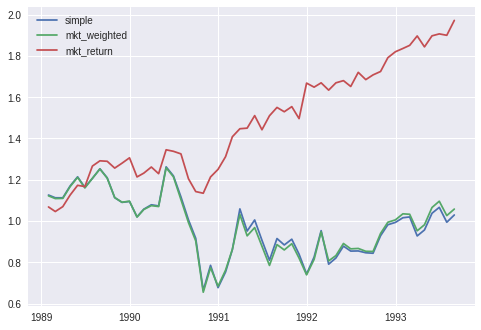

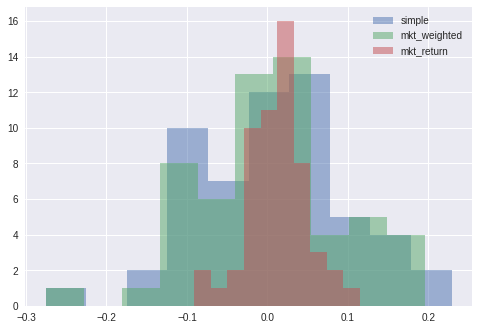

In [19]:
a1 = np.cumprod(1+np.array(simple_ret))
a2 = np.cumprod(1+np.array(weighted_ret))
a3 = np.cumprod(1+np.array(mkt_ret_list))


test_dates = pd.date_range(start = '1/1/1989',periods = 347,freq = 'M')

plt.figure()
plt.plot(test_dates[:len(a1)],a1)
plt.plot(test_dates[:len(a2)],a2)
plt.plot(test_dates[:len(a3)],a3)
plt.legend(["simple","mkt_weighted","mkt_return"])
    
    
    
    
plt.figure()
plt.hist(simple_ret,alpha = 0.5)
plt.hist(weighted_ret,alpha = 0.5)
plt.hist(np.array(mkt_ret_list),alpha = 0.5)
plt.legend(["simple","mkt_weighted","mkt_return"])
plt.show()